#### Adam Klie<br>04/08/2020
## Core microbial analysis

Requirements (so far):<br>
 - qiime2
 - viewing in qiime2

In [1]:
import qiime2
import warnings
warnings.filterwarnings('ignore')
from qiime2.plugins import metadata, feature_table, taxa, diversity, emperor, composition
from matplotlib import pyplot as plt

## 1. Feature table 

In [2]:
data_dir = '../../data/test_subset/'
results_dir = '../../results/test_subset/features/'

In [3]:
f_table = qiime2.Artifact.load('{}insertion-filtered-table.qza'.format(data_dir))
m_data = qiime2.Metadata.load('{}filtered-metadata.tsv'.format(data_dir))

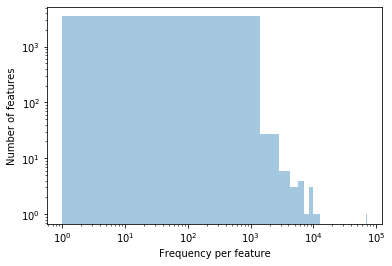

In [8]:
table_vis = feature_table.visualizers.summarize(table=f_table, sample_metadata=m_data)

In [5]:
table_vis.visualization

<visualization: Visualization uuid: b015cddc-94db-4782-8c07-cbf6833a641a>

## 2. Taxonomy
https://forum.qiime2.org/t/visualization-api/1023/3

In [7]:
tax = qiime2.Artifact.load('{}bespoke-taxonomy.qza'.format(data_dir))

In [8]:
taxonomy_vis = metadata.visualizers.tabulate(tax.view(qiime2.Metadata))

In [9]:
taxonomy_vis.visualization

<visualization: Visualization uuid: 2f7256b2-b1a2-4551-ad35-75d0b2962b85>

In [53]:
taxa_barplot = taxa.visualizers.barplot(f_table,
                                        tax,
                                        m_data)

In [54]:
#taxa_barplot.visualization

## 2. Phylogeny

In [9]:
%%bash
DATA_DIR=../../data/test_subset
RESULTS_DIR=../../results/test_subset
qiime empress plot \
    --i-tree ${DATA_DIR}/insertion-tree.qza \
    --i-feature-table ${DATA_DIR}/insertion-filtered-table.qza \
    --m-sample-metadata-file ${DATA_DIR}/filtered-metadata.tsv \
    --m-feature-metadata-file ${DATA_DIR}/bespoke-taxonomy.qza \
    --o-visualization ${RESULTS_DIR}/empress-tree.qzv

Saved Visualization to: ../../results/test_subset/empress-tree.qzv


In [19]:
results_dir = '../../results/test_subset/phylogeny/'
empress_tree = qiime2.Visualization.load('{}empress-tree.qzv'.format(results_dir))

In [ ]:
#empress_tree # May cause jlab to crash, may need to look into number of features

## 3. Alpha rarefaction

In [10]:
tree = qiime2.Artifact.load('{}insertion-tree.qza'.format(data_dir))

In [11]:
alpha_rarefaction = diversity.visualizers.alpha_rarefaction(f_table,
                                                            phylogeny=tree,
                                                            max_depth=10000,
                                                            metadata=m_data)

In [49]:
#alpha_rarefaction.visualization

## 4. Diversity

In [7]:
core_diversity = diversity.pipelines.core_metrics_phylogenetic(f_table,
                                                               phylogeny=tree,
                                                               sampling_depth=5000,
                                                               metadata=m_data,
                                                               n_jobs=1)

NameError: name 'tree' is not defined

In [117]:
shannon_vector = (core_diversity.shannon_vector.view(qiime2.Metadata)).to_dataframe()
shannon_vector.head()

,shannon
Sample ID,
10317.000041278.61470,5.260228
10317.000023110.57559,5.433126
10317.000014493.57741,6.155416
10317.000101322.62423,5.527051
10317.000033192.56773,5.388311


Populating the interactive namespace from numpy and matplotlib


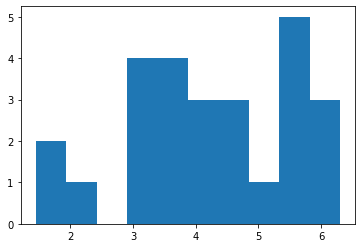

In [99]:
%pylab inline
fig = plt.figure()
fig = plt.hist(shannon_vector["shannon"])

### A. Alpha diversity

In [101]:
shannon_div = diversity.visualizers.alpha_group_significance(core_diversity.shannon_vector,
                                                             m_data)

In [102]:
#shannon_div.visualization

## B. Beta diversity

In [132]:
uw_unifrac_div = diversity.visualizers.beta_group_significance(core_diversity.unweighted_unifrac_distance_matrix,
                                                               metadata=m_data.get_column('sex'),
                                                               pairwise=True)
#https://forum.qiime2.org/t/plugin-error-from-diversity-alpha-rarefaction/4548/4

<Figure size 432x288 with 0 Axes>

In [6]:
core_diversity.unweighted_unifrac_emperor

NameError: name 'core_diversity' is not defined

# 5. Differential abundance testing

## A. ANCOM

In [20]:
high_abundance_table = feature_table.methods.filter_features(f_table,
                                                             min_samples=5,
                                                             min_frequency=20)

In [23]:
comp_table = composition.methods.add_pseudocount(high_abundance_table.filtered_table)

In [26]:
ancom_vis = composition.visualizers.ancom(comp_table.composition_table,
                              m_data.get_column('exercise_frequency'))

In [28]:
#ancom_vis.visualization

## B. Songbird (better choice)